In [457]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils


# Use MPS to speed up training

# dev = torch.device(
    # "mps") if torch.backends.mps.is_available() else torch.device("cpu")
dev = torch.device("cpu")

# Load training and validation data
train = pd.read_csv('train.csv')
# Drop id 
train.drop(['id'], axis=1, inplace=True)

# Split into x and y, converting to float tensors
x_train = torch.tensor(train.drop(['price'], axis=1).values).float()
y_train = torch.tensor(train['price'].values).float()


def torch_standardize(x):
    mean = torch.mean(x, dim=0)
    std = torch.std(x, dim=0)
    return (x - mean) / std

# Preprocess the data in a function
def preprocess(x):
    """Function for preprocessing the data before training. Currently normalizing,
    standardizing, and keeping the original values for the neural network. We 
    will pass all three concatenated to our model, and let it decide which ones
    to use.
    We will L2, L1 normalize and min/max normalize the features of x.
    """
    x_norm_2 = F.normalize(x, p=2, dim=0)
    x_norm_1 = F.normalize(x, p=1, dim=0)
    x_std = torch_standardize(x)
    # x_minmax = (x - torch.min(x, dim=0)[0]) / (torch.max(x, dim=0)[0] - torch.min(x, dim=0)[0])
    return torch.cat((x, x_norm_2, x_norm_1, x_std), dim=1)
    
x_train = preprocess(x_train)

train_dataset = TensorDataset(x_train, y_train)

# Split into train and val
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [458]:
# Define model
class HousePricesModel(nn.Module):
    def __init__(self):
        super(HousePricesModel, self).__init__()
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
def create_model_optimizer_loss(lr = 0.001):
    model = HousePricesModel().to(dev)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_func = nn.MSELoss(reduction='mean')
    return model, optimizer, loss_func


model, optimizer, loss_func = create_model_optimizer_loss()

def train(model,opt,epochs=10, train_dl=train_loader, val_dl=val_loader, loss_func=loss_func, dev=dev):
    loss_vals = []
    print("-"*30)
    print(f"Training model: {model.__class__.__name__}")
    print(f"Optimizer: {opt.__class__.__name__}")
    print()
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            xb, yb = xb.to(dev), yb.to(dev)
            y_hat = model(xb)
            y_hat = y_hat.squeeze()
            loss = loss_func(y_hat, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        model.eval()
        with torch.no_grad():
            tot_loss = 0
            for xb, yb in val_dl:
                xb, yb = xb.to(dev), yb.to(dev)
                y_hat = model(xb)
                y_hat = y_hat.squeeze()
                loss = loss_func(y_hat, yb)
                tot_loss += loss.item() 
            val_loss = tot_loss / len(val_dl)
            print(f"Epoch: {epoch}")
            print(f"Validation loss: {val_loss}")
            print()
            loss_vals.append(val_loss)

    return loss_vals

loss_vals = train(model,optimizer,epochs=100)

------------------------------
Training model: HousePricesModel
Optimizer: Adam

Epoch: 0
Validation loss: 6423517506218.667

Epoch: 1
Validation loss: 5534335791559.111

Epoch: 2
Validation loss: 5251401056256.0

Epoch: 3
Validation loss: 4583020611356.444

Epoch: 4
Validation loss: 3800466755128.8887

Epoch: 5
Validation loss: 2755581538759.1113

Epoch: 6
Validation loss: 1914990241564.4443

Epoch: 7
Validation loss: 1545272739612.4443

Epoch: 8
Validation loss: 1379347353600.0

Epoch: 9
Validation loss: 1140376234666.6667

Epoch: 10
Validation loss: 1012117559068.4445

Epoch: 11
Validation loss: 946937320561.7778

Epoch: 12
Validation loss: 888183631416.8889

Epoch: 13
Validation loss: 816124316785.7778

Epoch: 14
Validation loss: 768382925937.7778

Epoch: 15
Validation loss: 757095755320.8889

Epoch: 16
Validation loss: 695568037774.2222

Epoch: 17
Validation loss: 649674189027.5555

Epoch: 18
Validation loss: 692878903864.8889

Epoch: 19
Validation loss: 664682162858.6666

Epoch: 

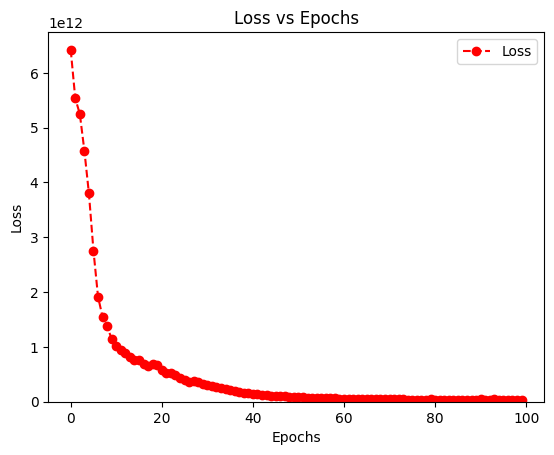

<Figure size 640x480 with 0 Axes>

In [462]:
import matplotlib.pyplot as plt
def plot_loss(loss_vals):
    plt.plot(loss_vals, label="Loss", color="red", linestyle="dashed", marker="o")
    plt.legend()
    # Add title to x axis
    plt.xlabel("Epochs")
    # Add title to y axis
    plt.ylabel("Loss")
    # Add title to graph
    plt.title("Loss vs Epochs")
    # Only show integer epochs 
    # Set y-axis to start at 0
    plt.ylim(0)

    # Plot accuracy in a seperate plot 
    plt.figure()
    # Plot


plot_loss(loss_vals);

In [463]:
# Load test data and create kaggle submission
test = pd.read_csv('test.csv')

# Drop id
test.drop(['id'], axis=1, inplace=True)

# Convert to tensor
x_test = torch.tensor(test.values).float()

# Preprocess test data
x_test = preprocess(x_test)

# Create test dataset
test_dataset = TensorDataset(x_test)

# Run model on test data
model.eval()
model(x_test)

# Create submission
submission = pd.read_csv('sample_submission.csv')
submission['price'] = model(x_test).detach().numpy()
submission.to_csv('submission.csv', index=False)


In [465]:
submission

,id,price
0,22730,4724919.50
1,22731,6192505.50
2,22732,9011544.00
3,22733,1643857.75
4,22734,6721657.00
...,...,...
15149,37879,8602547.00
15150,37880,4537909.50
15151,37881,7320923.50
15152,37882,7703126.50


In [468]:
%%bash
# Submit to kaggle
/Users/dbless/Library/Python/3.11/bin/kaggle competitions submit -c playground-series-s3e6 -f submission.csv -m "Submission VSCode1"

100%|██████████| 235k/235k [00:02<00:00, 103kB/s]


400 - Bad Request


CalledProcessError: Command 'b'# Submit to kaggle\n/Users/dbless/Library/Python/3.11/bin/kaggle competitions submit -c playground-series-s3e6 -f submission.csv -m "Submission VSCode1"\n'' returned non-zero exit status 1.